<a href="https://colab.research.google.com/github/Louisfhgr/BA_Arbeit/blob/main/Code/Zyklus/LOF_funktion_preproc_Zyklus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install loguru

In [23]:
import math
from abc import ABC, abstractmethod
from datetime import datetime

import geopy.distance
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from loguru import logger
from pyproj import Transformer
from scipy.signal import savgol_filter


class PhysicsComputer(ABC):
    """ Contains methods that are common for both SkiAlpine and SkiCrossCountry Class. It's the abstract base class
    that not will be initiated but that will be the blueprint for SkiAlpine and SkiCrossCountry classes."""

    DEFAULT_CONFIG = {
        'savitzky_golay': {
            'window_size':
                {'none': 11, 'DH': 11, 'SX': 11,'GS': 11, 'SL': 7, 'XC': 151},
            'order':
                {'none': 3, 'DH': 3, 'SX': 3, 'GS': 3, 'SL': 3, 'XC': 3}
        }
    }


    def __init__(self, df: pd.DataFrame, config:dict):
        """
        :param df: pandas DataFrame with raw data
        :param config: config dictionary that sets values for different filters aso.
        """
        self._original = df
        self._df = df
        self.config = config

    @abstractmethod
    def compute(self):
        """ Define method that executes all calculations for either SkiAlpine- or SkiCrossCountry-Instance"""
        pass

    def plot(self, feature: str|list[str] = None, title: str = None) -> go.Figure:
        """ Offers a simple plot-API to visualize a singe feature ort multiple features in time

        :param title: optional plot-title as string
        :param feature: feature to be visualized as string or list of features
        """
        features = []
        if feature is None:
            raise f"Please select a feature from DataFrame!"
        elif isinstance(feature, str) and feature not in self._df.columns:
            raise Exception(f"Feature {feature} not found")
        elif isinstance(feature, str) and feature in self._df.columns:
            features.append(feature)
        elif isinstance(feature, list):
            features = [i for i in feature if i in self._df.columns]
            if len(features) == 0:
                raise Exception(f"Feature {feature} not found")
            elif len(features) != len(feature):
                logger.info(f"Dropped {len(feature)- len(features)} feature(s)")

        if len(features) != 0:
            x = self._df['time'] if 'time' in self._df.columns else self._df.index
            title = dict(text=title if title is not None else f"feature: {','.join(features)}", font=dict(size=28))
            if len(features) > 1:
                fig = go.Figure()
                for i in range(len(features)):
                    fig.add_trace(go.Scatter(x=x, y=self._df[features[i]],
                                             mode='lines',
                                             name=features[i]))
            else:
                fig = px.line(self._df, x=x, y=features[0], title=f'{",".join(features)}'.upper())
            fig.update_layout(template='plotly_white', title=title)
            return fig

    def export_csv(self, path: str) -> None:
        """ Exports calculated data to a .csv-File.

        :param path: output-path as string
        """
        EXPORTED_COLUMNS = ['elevation', 'latitude', 'longitude','tf_id', 'discipline_from_name', 'time', 'date',
                            'x_norm', 'y_norm', 'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
                            'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp', 'v_elevation_sp',
                            'a_elevation_sp', 'k', 'k_xy', 'distance', 'distance_x_y', 'v']
        df = self._df[EXPORTED_COLUMNS].copy()
        df.to_csv(path, index=False)

    @staticmethod
    def _transform_to_x_y(coord1: tuple, coord2: tuple) -> (float, float):
        """ Actually transforms the coordinates x and y
        source: https://chatgpt.com/c/71f7ea04-2b95-4b07-96ee-fc5ccbf41532

        :param coord1: tuple containing latitude and longitude of starting point; exp: (46.5, 8.3)
        :param coord2: tuple containing latitude and longitude of ending point; exp: (46.5, 8.3)
        :return: tuple containing 2 floats with distance in meters between the 2 given coordinates in x and y direction
        """
        utm_zone = math.ceil((coord1[1] + 180) / 6)
        hemisphere = 'N' if coord1[0] >= 0 else 'S'
        wgs84 = 'epsg:4326'
        utm = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +{'south' if hemisphere == 'S' else 'north'}"
        transformer = Transformer.from_crs(wgs84, utm)
        x1, y1 = transformer.transform(coord1[0], coord1[1])
        x2, y2 = transformer.transform(coord2[0], coord2[1])
        relative_x = x2 - x1
        relative_y = y2 - y1
        return relative_x, relative_y

    @staticmethod
    def _apply_savitzky_golay(dff: pd.DataFrame, filter_for: tuple, window_size: int, order: int) -> pd.DataFrame:
        """ Applies smoothing with Savitzky-Golay to given columns in pandas DataFrame with certain window_size and order

        :param dff: pandas DataFrame with raw data
        :param filter_for: tuple with column-names in DataFrame as string that should be modified
        :param window_size: length of Savitzky-Golay window as integer
        :param order: order of Savitzky-Golay Filter
        :return: modified pandas DataFrame
        """
        # https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
        # https://gist.github.com/krvajal/1ca6adc7c8ed50f5315fee687d57c3eb
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

        for item in filter_for:
            if item not in dff.columns:
                continue

            val = dff[item].values
            dff[f"{item}_sp"] = savgol_filter(val, window_size, order)
            dff[f"v_{item}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            dff[f"a_{item}_sp"] = savgol_filter(val, window_size, order, deriv=2)

        return dff

    def _modify_config(self, config: dict=None) -> dict:
        """ Modifies config file with the goal that all needed values are existing. If they do not exist in given config
        discipline specific default values from parent class will be taken, else given values will be taken.

        :param config: optional config dictionary that contains values for different filters and settings.
        :return: modified_config (merged with discipline specific DEFAULT_CONFIG from PhysicsComputer) with all needed values
        """
        def _merge_dicts(config, modified_config):
            for key, value in config.items():
                if isinstance(value, dict) and key in modified_config:
                    _merge_dicts(value, modified_config[key])
                else:
                    if key in modified_config:
                        modified_config[key] = value
            return modified_config

        if 'discipline_from_name' not in self._df.columns:
            raise Exception("discipline_from_name not defined in initial DataFrame!")

        discipline = self._df['discipline_from_name'].iloc[0]

        ws = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('window_size').get(discipline)
        order = PhysicsComputer.DEFAULT_CONFIG.get('savitzky_golay').get('order').get(discipline)
        modified_config = {}
        modified_config.update({'savitzky_golay': {'window_size': ws, 'order': order}})

        if config is not None:
            modified_config = _merge_dicts(config, modified_config)

        if not 'savitzky_golay' in modified_config or not 'window_size' in modified_config[
            'savitzky_golay'] or not 'order' in modified_config['savitzky_golay']:
            raise Exception(f"Something went wrong with initialisation of config! config: {config}")

        return modified_config

    def _convert_timestamp(self) -> None:
        """ Modifies timestamp from format "%Y%m%dT%H%M%S%f" to separate columns date "%Y-%m-%d" and time "%H:%M:%S."
        as string.
        """
        self._df['datetime'] = pd.to_datetime(self._df['timestamp'], format='%Y%m%dT%H%M%S%f')
        self._df["time"] = self._df["datetime"].dt.strftime("%H:%M:%S.") + (
                    self._df['datetime'].dt.microsecond // 100000).astype(str)
        self._df["date"] = self._df["datetime"].dt.strftime("%Y-%m-%d")
        self._df = self._df.drop(columns=["datetime"])

    def _compute_x_y_z(self) -> None:
        """ Transforms the original coordinates in x and y coordinates in meters and x_rel, y_rel and z_rel as difference
        between 2 measuring points. The starting point for x and y will always be at (0,0)
        """

        self._df = self._df.reset_index(drop=True)
        # transform columns to numeric columns -> all non-numeric values will be set to nan
        self._df['latitude'] = pd.to_numeric(self._df['latitude'], errors="coerce")
        self._df['longitude'] = pd.to_numeric(self._df['longitude'], errors="coerce")
        self._df.dropna(subset=['longitude', 'latitude'], inplace=True)
        # calculates distance im meters from actoil location to starting point
        self._df['x_y_from_origin'] = self._df.apply(
            lambda x: self._transform_to_x_y((self._df.loc[0, 'latitude'], self._df.loc[0, 'longitude']),
                                       (x['latitude'], x['longitude'])), axis=1)
        self._df[['x_norm', 'y_norm']] = pd.DataFrame(self._df['x_y_from_origin'].tolist(), index=self._df.index)
        self._df['x_rel'] = self._df['x_norm'].diff()
        self._df['y_rel'] = self._df['y_norm'].diff()
        if 'z' in self._df.columns:
            self._df['z_rel'] = self._df['z'].diff()
        self._df.drop('x_y_from_origin', axis=1, inplace=True)

    def _compute_savitzky_golay_and_derivatives(self) -> None:
        """ Calls savitzky-golay-filter for defined features
        """
        filter_for =  ('x_norm', 'y_norm', 'elevation')
        self._df = self._apply_savitzky_golay(dff=self._df,
                                        filter_for=filter_for,
                                        window_size=self.config['savitzky_golay']['window_size'],
                                        order=self.config['savitzky_golay']['order'])

    def _compute_k(self) -> None:
        """ Computes 'curvature'
        """
        def _calc_k_3D(row: pd.Series) -> float:
            v = [row['v_x_norm_sp'], row['v_y_norm_sp'], row['v_elevation_sp']]
            a = [row['a_x_norm_sp'], row['a_y_norm_sp'], row['a_elevation_sp']]
            cp = np.cross(v, a)
            l = math.sqrt(cp[0] ** 2 + cp[1] ** 2 + cp[2] ** 2)
            v_sp = math.sqrt(row['v_x_norm_sp'] ** 2 + row['v_y_norm_sp'] ** 2 + row['v_elevation_sp'] ** 2)
            return l / v_sp ** 3

        self._df['k'] = self._df.apply(lambda row: pd.Series(_calc_k_3D(row)), axis=1)

    def _compute_k_xy(self) -> None:
        """ Calculates 'curvature' in 2-dimensional-space (x-y-plane)
        """

        def _calc_k_2D(row: pd.Series) -> float:
            vx, vy = row['v_x_norm_sp'], row['v_y_norm_sp']  # 2D-Geschwindigkeitskomponenten
            ax, ay = row['a_x_norm_sp'], row['a_y_norm_sp']  # 2D-Beschleunigungskomponenten
            cp = vx * ay - vy * ax  # 2D-"Kreuzprodukt" (nur Betrag für xy-Ebene)
            v_sp = math.sqrt(vx ** 2 + vy ** 2) # Betrag der Geschwindigkeit in 2D
            return abs(cp) / v_sp ** 3

        self._df['k_xy'] = self._df.apply(lambda row: pd.Series(_calc_k_2D(row)), axis=1)

    def _compute_distances(self) -> None:
        """ Computes distances between 2 coordinate-points
        """
        # add shifts to x_norm, y_norm, latitude and longitude
        self._df['shifted_x_norm'] = self._df['x_norm'].shift(periods=1)
        self._df['shifted_y_norm'] = self._df['y_norm'].shift(periods=1)
        self._df['shifted_latitude'] = self._df['latitude'].shift(periods=1)
        self._df['shifted_longitude'] = self._df['longitude'].shift(periods=1)

        def _calculate_distance(row: pd.Series) -> float:
            """ Calculation of distance in meters between 2 coordinate points based on original longitude and latitude

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance between last 2 coordinate points in meters
            """

            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            return geopy.distance.geodesic((row['latitude'], row['longitude']),
                                           (row['shifted_latitude'], row['shifted_longitude'])).m

        def _calculate_distance_from_x_y(row: pd.Series) -> float:
            """ Calculation of distance in meters based on transformed x and y (metric) coordinates. This calculation is used
            to validate either coordinate transformation and calculation of distance

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a distance in [m] between 2 coordinates
            """
            if row.isnull()['shifted_x_norm'] or row.isnull()['shifted_y_norm']:
                return 0
            distance = math.sqrt(
                (row['x_norm'] - row['shifted_x_norm']) ** 2 + (row['y_norm'] - row['shifted_y_norm']) ** 2)
            return distance

        self._df['distance'] = self._df.apply(_calculate_distance, axis=1)
        self._df['distance_x_y'] = self._df.apply(_calculate_distance_from_x_y, axis=1)

    def _compute_v(self) -> None:
        """ Calculates speed
        """
        def _calculate_time_delta(df: pd.DataFrame) -> pd.DataFrame:
            """ Transforms single columns 'date' and 'time' to a date_time column in the datetime-format with tenth of a second
            ('%Y-%m-%d %H:%M:%S.%f') and adds feature 'time_delta' that is 'date_time' shifted by one period.

            :param df: pandas DataFrame with raw data
            :return: modified pandas DataFrame with added/modified date_time content
            """
            df["date_time"] = df["date"] + " " + df["time"]

            try:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))
            except ValueError:
                df['date_time'] = df['date_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

            df['shifted_date_time'] = df['date_time'].shift(periods=1)
            df.loc[0, 'shifted_date_time'] = df.loc[0, 'date_time']
            df['time_delta'] = df['date_time'] - df['shifted_date_time']
            df['time_delta'] = df['time_delta'].apply(lambda x: x.total_seconds())
            return df

        def _calculate_speed(row: pd.Series) -> float:
            """ Calculates the speed in [m/s] based on distance between 2 calculated x and y coordinates and the according
            time-gap between this 2 coordinates

            :param row: a pandas Series with a single row of pandas DataFrame for a single athlete in a single run
            :return: a speed calculation in [m/s] as float
            """
            if row['time_delta'] == 0:
                return 0
            speed = row['distance_x_y'] / row['time_delta']
            return speed

        self._df = _calculate_time_delta(self._df)
        self._df["v"] = self._df.apply(lambda row: pd.Series(_calculate_speed(row)), axis=1)

In [24]:
import pandas as pd
from loguru import logger



class SkiCrossCountry(PhysicsComputer):
    def __init__(self, df: pd.DataFrame, config:dict=None):
        """
        :param df: pandas DataFrame with raw values
        :param config: optional config dictionary that sets values for different filters aso.
        """
        self._df = df
        config = self._modify_config(config)
        super().__init__(df, config)

    @staticmethod
    def _compute_xc_specific_physical_size() -> None:
        """ Computes cross-country-specific physical sizes (at the moment none).
        """
        logger.info("xc specific")

    def compute(self):
        self._convert_timestamp()
        self._compute_x_y_z()
        self._compute_savitzky_golay_and_derivatives()
        self._compute_k()
        self._compute_k_xy()
        self._compute_distances()
        self._compute_v()
        self._compute_xc_specific_physical_size()
        return self._df


-------------------------------------------------------------------------

## Daten hochladen

In [25]:
import os
print(os.listdir())

['.config', 'export_data_transformed_lof.xlsx', 'Goms_2024-01-27_nadine_faehndrich_run_2.csv', 'Goms_2024-01-27_nadine_faehndrich_run_1.csv', 'sample_data']


In [26]:
import os
import pandas as pd

def import_data_and_merge(
    run_csv_name="Goms_2024-01-27_nadine_faehndrich_run_1.csv",
    export_file_name="export_data_transformed_lof.xlsx",  # kann .csv oder .xlsx sein
    name_filter="FAEHNDRICH Nadine Run__1",
    extract_folder=""
):
    # Haupt-CSV laden
    csv_main_path = os.path.join(extract_folder, run_csv_name)
    df_modified = pd.read_csv(csv_main_path)

    # Verarbeite mit SkiCrossCountry
    xc = SkiCrossCountry(df=df_modified)
    df_modified = xc.compute()

    # Prüfe, ob Export-Datei existiert
    if export_file_name not in os.listdir():
        raise FileNotFoundError(f"{export_file_name} wurde nicht gefunden. Bitte Datei hochladen.")

    # Lade exportierte Transformationsdaten – je nach Dateityp
    if export_file_name.endswith(".csv"):
        df_gears = pd.read_csv(export_file_name)
    elif export_file_name.endswith(".xlsx"):
        df_gears = pd.read_excel(export_file_name)
    else:
        raise ValueError("Nur .csv oder .xlsx werden als export_file_name unterstützt.")

    # Filtere relevante Zeile(n)
    df_filtered = df_gears[df_gears["name_run"] == name_filter]

    if df_filtered.empty:
        raise ValueError(f"Kein Eintrag mit name_run = '{name_filter}' gefunden.")

    # Mappe Technik auf df_modified
    df_modified["technic"] = df_modified["time"].map(
        df_filtered.set_index("time")["technic"]
    )

    print(name_filter)
    print("Techniken im DataFrame:", df_modified["technic"].unique())

    return df_modified


In [27]:
# Direkt von Git sofern öffentlich

!wget https://raw.githubusercontent.com/Louisfhgr/BA_Arbeit/main/Code/Zyklus/Goms_2024-01-27_nadine_faehndrich_run_1.csv

!wget https://raw.githubusercontent.com/Louisfhgr/BA_Arbeit/main/Code/Zyklus/Goms_2024-01-27_nadine_faehndrich_run_2.csv

!wget https://raw.githubusercontent.com/Louisfhgr/BA_Arbeit/main/Code/Zyklus/export_data_transformed_lof.xlsx

--2025-05-12 13:44:04--  https://raw.githubusercontent.com/Louisfhgr/BA_Arbeit/main/Code/Zyklus/Goms_2024-01-27_nadine_faehndrich_run_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122780 (120K) [text/plain]
Saving to: ‘Goms_2024-01-27_nadine_faehndrich_run_1.csv.1’

Goms_2024-01-27_nad 100%[===================>] 119.90K  --.-KB/s    in 0.03s   

2025-05-12 13:44:04 (4.40 MB/s) - ‘Goms_2024-01-27_nadine_faehndrich_run_1.csv.1’ saved [122780/122780]

--2025-05-12 13:44:04--  https://raw.githubusercontent.com/Louisfhgr/BA_Arbeit/main/Code/Zyklus/Goms_2024-01-27_nadine_faehndrich_run_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.

In [28]:
df = import_data_and_merge("Goms_2024-01-27_nadine_faehndrich_run_2.csv", "export_data_transformed_lof.xlsx", "FAEHNDRICH Nadine Run__2")
print(df.columns)

df

2025-05-12 13:44:41.464 | INFO     | __main__:_compute_xc_specific_physical_size:20 - xc specific


FAEHNDRICH Nadine Run__2
Techniken im DataFrame: [nan  7.  3.  4.  2.  6.  5.]
Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v',
       'technic'],
      dtype='object')


,latitude,longitude,elevation,speed_measured,timestamp,discipline_from_name,tf_id,time,date,x_norm,...,shifted_y_norm,shifted_latitude,shifted_longitude,distance,distance_x_y,date_time,shifted_date_time,time_delta,v,technic
0,46.500459,8.302499,1346.345,10.9,20240127T144159900000,XC,11783,14:41:59.9,2024-01-27,0.000000,...,NaN,NaN,NaN,0.000000,0.000000,2024-01-27 14:41:59.900,2024-01-27 14:41:59.900,0.0,0.000000,NaN
1,46.500458,8.302496,1346.570,11.6,20240127T144200000000,XC,11783,14:42:00.0,2024-01-27,-0.254880,...,0.000000,46.500459,8.302499,0.316037,0.315922,2024-01-27 14:42:00.000,2024-01-27 14:41:59.900,0.1,3.159216,7.0
2,46.500457,8.302493,1346.640,10.1,20240127T144200100000,XC,11783,14:42:00.1,2024-01-27,-0.478087,...,-0.186661,46.500458,8.302496,0.235817,0.235731,2024-01-27 14:42:00.100,2024-01-27 14:42:00.000,0.1,2.357315,7.0
3,46.500455,8.302488,1346.806,13.1,20240127T144200200000,XC,11783,14:42:00.2,2024-01-27,-0.825633,...,-0.262478,46.500457,8.302493,0.429754,0.429597,2024-01-27 14:42:00.200,2024-01-27 14:42:00.100,0.1,4.295972,7.0
4,46.500452,8.302484,1346.834,14.2,20240127T144200300000,XC,11783,14:42:00.3,2024-01-27,-1.173179,...,-0.514996,46.500455,8.302488,0.429754,0.429597,2024-01-27 14:42:00.300,2024-01-27 14:42:00.200,0.1,4.295972,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,46.500643,8.302157,1351.395,28.9,20240127T144504700000,XC,11783,14:45:04.7,2024-01-27,-26.015895,...,21.026178,46.500647,8.302167,0.816320,0.816022,2024-01-27 14:45:04.700,2024-01-27 14:45:04.600,0.1,8.160221,3.0
1849,46.500639,8.302149,1351.418,28.6,20240127T144504800000,XC,11783,14:45:04.8,2024-01-27,-26.687084,...,20.610106,46.500643,8.302157,0.784319,0.784033,2024-01-27 14:45:04.800,2024-01-27 14:45:04.700,0.1,7.840333,NaN
1850,46.500635,8.302140,1351.376,28.3,20240127T144504900000,XC,11783,14:45:04.9,2024-01-27,-27.358372,...,20.204874,46.500639,8.302149,0.790205,0.789917,2024-01-27 14:45:04.900,2024-01-27 14:45:04.800,0.1,7.899172,NaN
1851,46.500631,8.302131,1351.353,28.4,20240127T144505000000,XC,11783,14:45:05.0,2024-01-27,-28.022183,...,19.788531,46.500635,8.302140,0.795932,0.795642,2024-01-27 14:45:05.000,2024-01-27 14:45:04.900,0.1,7.956415,NaN


# Pyhsics-computer abrufen

In [29]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


def Savitzky_golay(
    df: pd.DataFrame,
    filter_for: tuple = ("x_norm", "y_norm", "elevation"),
    window_size: int = 11,
    order: int = 3,
    plot: bool = True,
    plot_2d: bool = True,
    plot_3d: bool = True
) -> pd.DataFrame:
    """
    Wendet Savitzky-Golay-Filter auf ausgewählte Spalten an und plottet Zeitreihen + optional 2D/3D-Projektion.

    Args:
        df (pd.DataFrame): DataFrame mit den Daten.
        filter_for (tuple): Spalten, die geglättet und geplottet werden sollen.
        window_size (int): Fenstergröße für den Filter.
        order (int): Ordnung des Filters.
        plot (bool): Zeitreihen-Plot.
        plot_2d (bool): 2D-Projektions-Plot.
        plot_3d (bool): 3D-Projektions-Plot.

    Returns:
        pd.DataFrame: Modifiziertes DataFrame mit neuen *_sp-Spalten.
    """

    # === Glättung ===
    for col in filter_for:
        if col not in df.columns:
            print(f"Spalte '{col}' nicht gefunden – übersprungen.")
            continue
        val = df[col].values
        try:
            df[f"{col}_sp"] = savgol_filter(val, window_size, order)
            df[f"v_{col}_sp"] = savgol_filter(val, window_size, order, deriv=1)
            df[f"a_{col}_sp"] = savgol_filter(val, window_size, order, deriv=2)
        except Exception as e:
            print(f" Fehler bei '{col}': {e}")

    # === Zeitreihenplot ===
    if plot:
        plt.figure(figsize=(12, 6))
        try:
            time_series = pd.to_datetime(df["time"], format="%H:%M:%S.%f")
        except:
            try:
                time_series = pd.to_datetime(df["time"])
            except:
                time_series = df.index

        colors = ["red", "blue", "green", "orange", "purple"]
        for i, col in enumerate(filter_for):
            a_col = f"a_{col}_sp"
            if a_col in df.columns:
                plt.plot(time_series, df[a_col], label=f"a_{col}_sp", color=colors[i % len(colors)], alpha=0.8)

        if "technic" in df.columns:
            unique_technic = df["technic"].dropna().unique()
            technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
            technic_values = df["technic"].map(technic_mapping)
            bg_colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))

            for idx, (label, color) in enumerate(zip(technic_mapping.keys(), bg_colors)):
                mask = technic_values == idx
                plt.fill_between(time_series, -0.03, 0.03, where=mask, color=color, alpha=0.3, label=f"Technic: {label}")

        plt.xlabel("Zeit")
        plt.ylabel("Beschleunigung (m/s²)")
        plt.title("Savitzky-Golay-geglättete Beschleunigungen")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # === 2D-Projektion ===
    if plot_2d and all(f"a_{col}_sp" in df.columns for col in ("x_norm", "y_norm")):
        x = df["a_x_norm_sp"]
        y = df["a_y_norm_sp"]
        technic = df["technic"] if "technic" in df.columns else None

        plt.figure(figsize=(6, 6))
        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.Set1(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=0.8)

            legend_patches = [
                plt.Line2D([0], [0], color=color, lw=3, label=f"Technic: {gear}")
                for gear, color in technic_mapping.items()
            ]
            plt.legend(handles=legend_patches, loc="upper right")
        else:
            plt.plot(x, y, color="blue", alpha=0.8)

        plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")
        plt.xlabel("a_x (m/s²)")
        plt.ylabel("a_y (m/s²)")
        plt.title("2D-Projektion der gefilterten Beschleunigung")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # === 3D-Projektion ===
    if plot_3d and all(f"a_{col}_sp" in df.columns for col in ("x_norm", "y_norm", "elevation")):
        x = df["a_x_norm_sp"]
        y = df["a_y_norm_sp"]
        z = df["a_elevation_sp"]
        technic = df["technic"] if "technic" in df.columns else None

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")

        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=color, alpha=0.8)

            for gear, color in technic_mapping.items():
                ax.scatter([], [], [], color=color, label=f"Technic: {gear}")

        else:
            ax.plot(x, y, z, color="blue", alpha=0.8)

        ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")
        ax.set_xlabel("a_x (m/s²)")
        ax.set_ylabel("a_y (m/s²)")
        ax.set_zlabel("a_z (m/s²)")
        ax.set_title("3D-Projektion der Inner-Body-Bewegung")
        ax.legend()
        plt.tight_layout()
        plt.show()

    return df


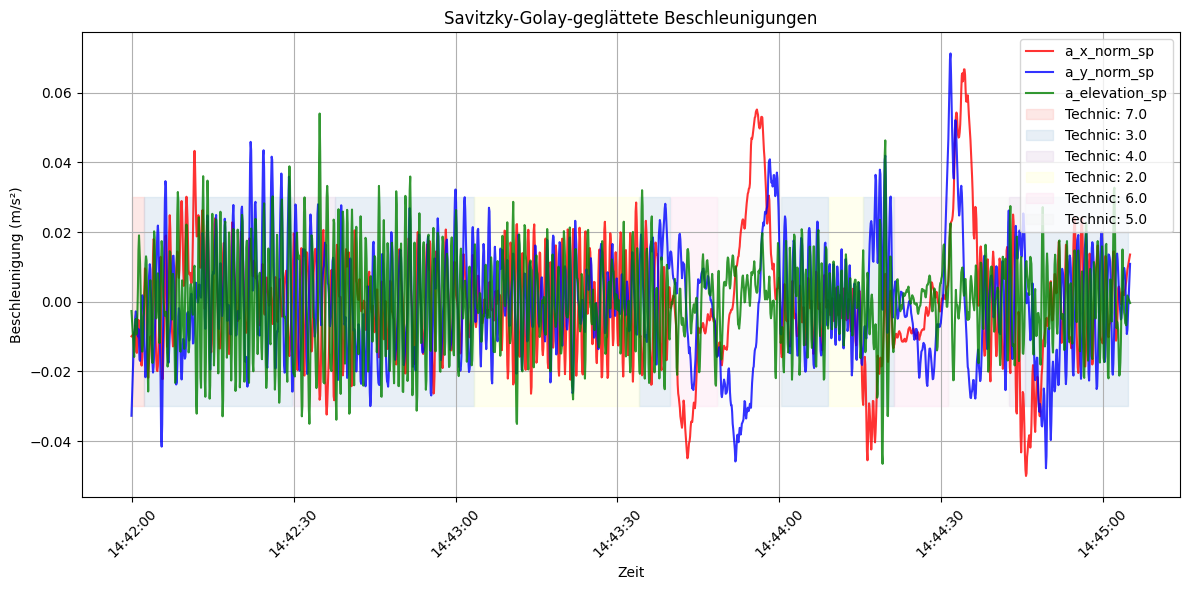

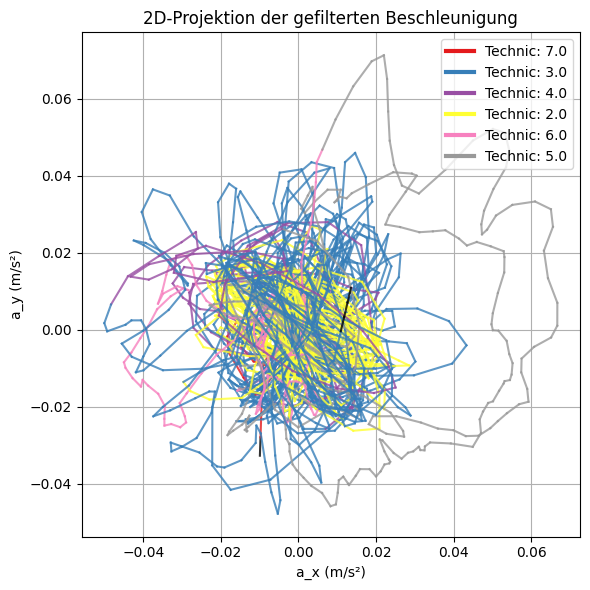

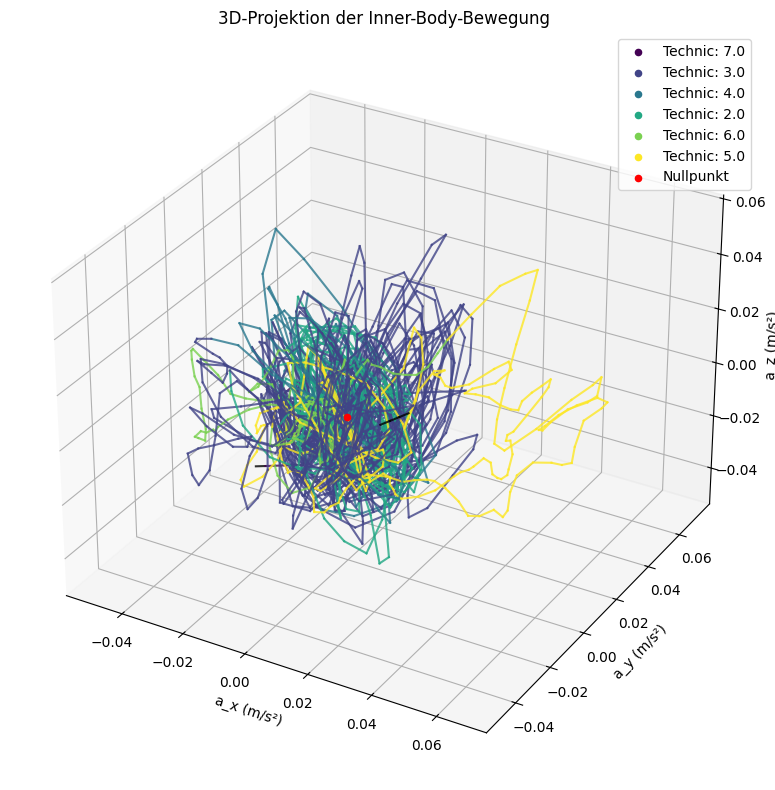

In [30]:
df = Savitzky_golay(df,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)


## Zeitreihe Beschleunigung Plotten

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def signal_projection(
    df: pd.DataFrame,
    signal_columns: tuple = ("a_x_norm_sp", "a_y_norm_sp", "a_elevation_sp"),
    plot: bool = True,
    plot_2d: bool = True,
    plot_3d: bool = True
) -> pd.DataFrame:
    """
    Visualisiert gegebene Beschleunigungssignale (ohne Savitzky-Golay).

    Args:
        df (pd.DataFrame): Eingabedaten mit gefilterten Spalten.
        signal_columns (tuple): Spaltennamen der Signale zur Anzeige.
        plot (bool): Zeitreihen-Plot anzeigen.
        plot_2d (bool): 2D-Projektionsplot.
        plot_3d (bool): 3D-Projektionsplot.

    Returns:
        pd.DataFrame: Unverändertes DataFrame.
    """
    # === Zeitreihenplot ===
    if plot:
        plt.figure(figsize=(12, 6))
        try:
            time_series = pd.to_datetime(df["time"], format="%H:%M:%S.%f")
        except:
            try:
                time_series = pd.to_datetime(df["time"])
            except:
                time_series = df.index

        colors = ["red", "blue", "green", "orange", "purple"]
        for i, col in enumerate(signal_columns):
            if col in df.columns:
                plt.plot(time_series, df[col], label=col, color=colors[i % len(colors)], alpha=0.8)

        if "technic" in df.columns:
            unique_technic = df["technic"].dropna().unique()
            technic_mapping = {label: idx for idx, label in enumerate(unique_technic)}
            technic_values = df["technic"].map(technic_mapping)
            bg_colors = plt.cm.Pastel1(np.linspace(0, 1, len(technic_mapping)))

            for idx, (label, color) in enumerate(zip(technic_mapping.keys(), bg_colors)):
                mask = technic_values == idx
                # Dynamische Höhe der Technic-Balken
                signal_min = df[list(signal_columns)].min().min()
                signal_max = df[list(signal_columns)].max().max()
                band_height = 0.1 * (signal_max - signal_min)  # 10% vom Gesamtbereich
                bottom = signal_min - 0.05 * abs(signal_min)    # kleiner Puffer
                top = bottom + band_height

                plt.fill_between(time_series, bottom, top, where=mask, color=color, alpha=0.3, label=f"Technic: {label}")





        plt.xlabel("Zeit")
        plt.ylabel("Beschleunigung (m/s²)")
        plt.title("Sensorwerte (ungefiltert)")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        """

    # === 2D-Projektion ===
    if plot_2d and all(col in df.columns for col in signal_columns[:2]):
        x = df[signal_columns[0]]
        y = df[signal_columns[1]]
        technic = df["technic"] if "technic" in df.columns else None

        plt.figure(figsize=(6, 6))
        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.Set1(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                plt.plot(x[i:i+2], y[i:i+2], color=color, alpha=0.8)

            legend_patches = [
                plt.Line2D([0], [0], color=color, lw=3, label=f"Technic: {gear}")
                for gear, color in technic_mapping.items()
            ]
            plt.legend(handles=legend_patches, loc="upper right")
        else:
            plt.plot(x, y, color="blue", alpha=0.8)

        plt.scatter(0, 0, color="red", marker="o", label="Nullpunkt")
        plt.xlabel(signal_columns[0])
        plt.ylabel(signal_columns[1])
        plt.title("2D-Projektion der Sensorwerte")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # === 3D-Projektion ===
    if plot_3d and len(signal_columns) == 3 and all(col in df.columns for col in signal_columns):
        x = df[signal_columns[0]]
        y = df[signal_columns[1]]
        z = df[signal_columns[2]]
        technic = df["technic"] if "technic" in df.columns else None

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")

        if technic is not None:
            unique_technic = technic.dropna().unique()
            colors = plt.cm.viridis(np.linspace(0, 1, len(unique_technic)))
            technic_mapping = {label: colors[i] for i, label in enumerate(unique_technic)}

            for i in range(len(x) - 1):
                color = technic_mapping.get(technic.iloc[i], "black")
                ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=color, alpha=0.8)

            for gear, color in technic_mapping.items():
                ax.scatter([], [], [], color=color, label=f"Technic: {gear}")
        else:
            ax.plot(x, y, z, color="blue", alpha=0.8)

        ax.scatter(0, 0, 0, color="red", marker="o", label="Nullpunkt")
        ax.set_xlabel(signal_columns[0])
        ax.set_ylabel(signal_columns[1])
        ax.set_zlabel(signal_columns[2])
        ax.set_title("3D-Projektion der Sensorwerte")
        ax.legend()
        plt.tight_layout()
        plt.show()

        """

    return


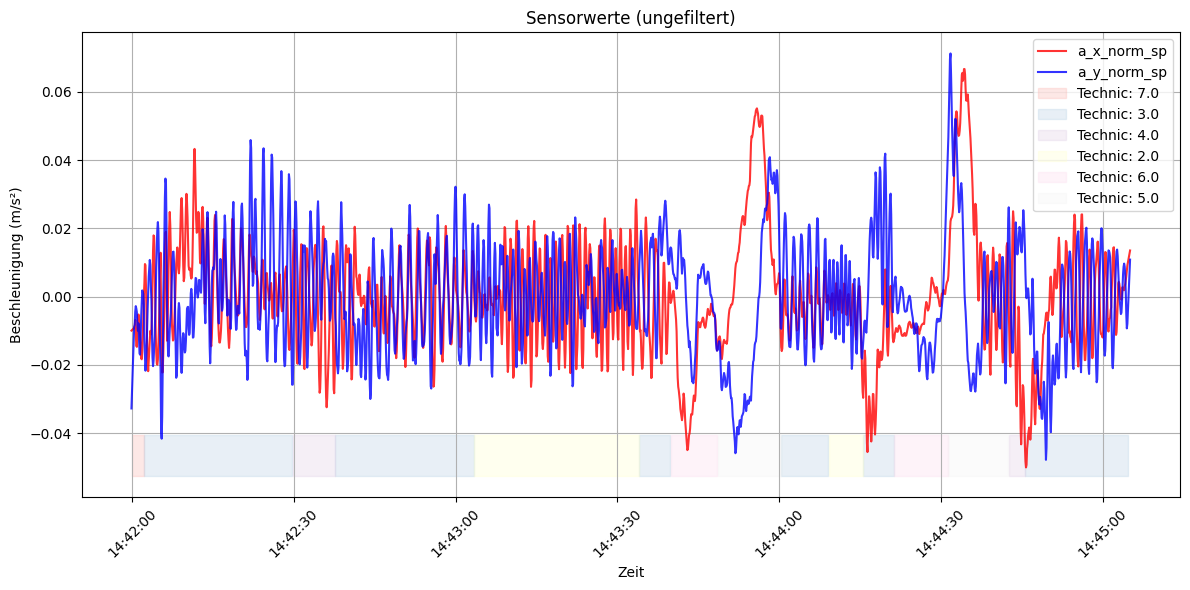

In [32]:
signal_projection(df, signal_columns=("a_x_norm_sp", "a_y_norm_sp"))

## Strecke plotten (x, y)

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

def plot_technic_track(
    df: pd.DataFrame,
    lat_col: str = "latitude",
    lon_col: str = "longitude",
    technic_col: str = "technic"
):
    """
    Zeichnet eine durchgehende Strecke basierend auf lat/lon mit farblicher Unterscheidung der Techniken.
    Args:
        df (pd.DataFrame): DataFrame mit GPS-Daten.
        lat_col (str): Name der Latitude-Spalte.
        lon_col (str): Name der Longitude-Spalte.
        technic_col (str): Spalte zur Farbcodierung (optional).
    """
    if lat_col not in df.columns or lon_col not in df.columns:
        raise ValueError(f"Spalten '{lat_col}' oder '{lon_col}' fehlen im DataFrame.")

    lat = df[lat_col].to_numpy()
    lon = df[lon_col].to_numpy()

    # Erzeuge Liniensegmente (n-1 Stück)
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Farbwerte für jedes Segment
    if technic_col in df.columns and not df[technic_col].isna().all():
        technic_series = df[technic_col].ffill().bfill().to_numpy()
        unique_techs = pd.unique(technic_series)
        tech_mapping = {val: idx for idx, val in enumerate(unique_techs)}
        color_indices = np.array([tech_mapping[t] for t in technic_series])
        segment_colors = color_indices[:-1]
        colormap = plt.cm.Set1(np.linspace(0, 1, len(tech_mapping)))

        # Zeichne mit LineCollection
        fig, ax = plt.subplots(figsize=(14, 7))
        lc = LineCollection(segments, colors=[colormap[i] for i in segment_colors], linewidth=2)
        ax.add_collection(lc)

        # Achsenlimits
        ax.set_xlim(lon.min(), lon.max())
        ax.set_ylim(lat.min(), lat.max())

        # Legende manuell erstellen
        legend_elements = [
            Line2D([0], [0], color=colormap[i], lw=3, label=str(label))
            for label, i in tech_mapping.items()
        ]
        ax.legend(handles=legend_elements, title="Technic")

    else:
        # Fallback: Einfarbige Strecke
        plt.plot(lon, lat, color="black", linewidth=2, label="Strecke")
        plt.legend()

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Strecke mit Technic-Färbung (wenn vorhanden)")
    ax.grid(True)
    ax.set_aspect("equal")
    plt.tight_layout()
    plt.show()


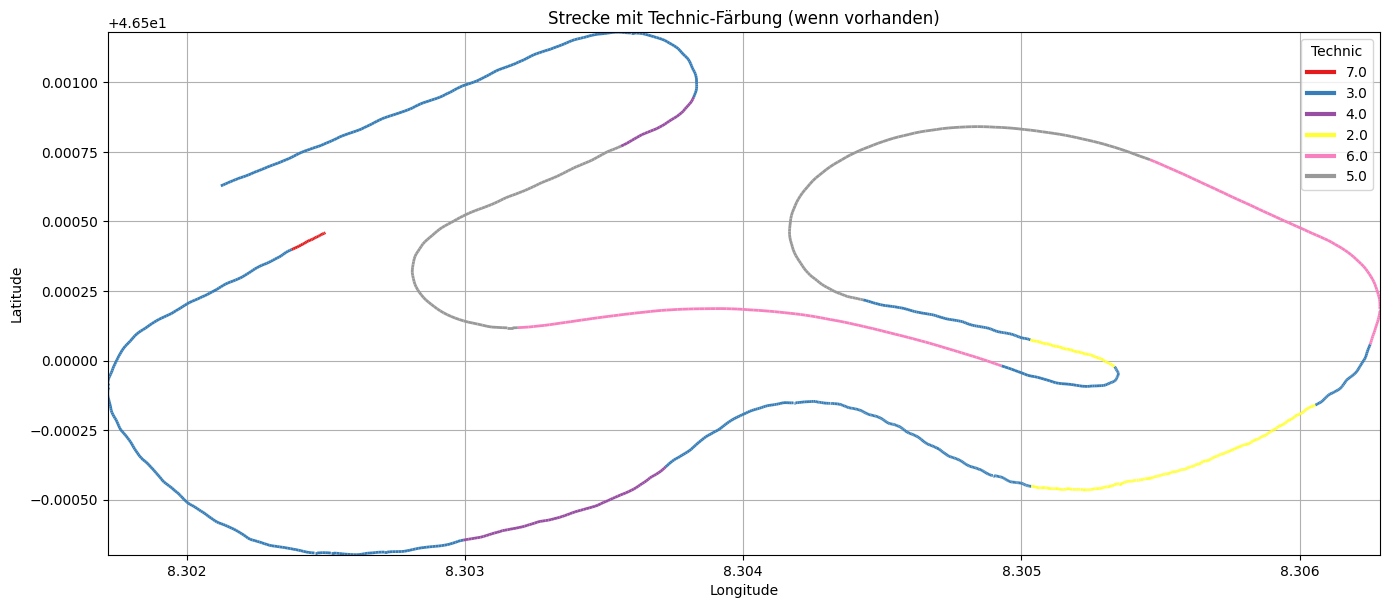

In [34]:
plot_technic_track(df, lat_col="latitude", lon_col="longitude", technic_col="technic")


# Testdaten erzeugen (Halbkreis mit Innerbody)



*   Ziel a_lr/a_vz
*   Lattitude / Longitude



In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_testdata_LOF(
    R: float,
    V: float,
    periods: int = 24,
    A_xLR: float = 0.8,
    A_yVZ: float = 1.0,
    num: int = 70,
    show_plot: bool = True
) -> pd.DataFrame:
    """
    Erzeugt Testdaten mit starker Körperbewegung (LOF) über eine Kreisbahn.

    Args:
        R (float): Radius der Kreisbahn in Metern.
        V (float): Geschwindigkeit in m/s.
        periods (int): Anzahl innerer Schwankungsperioden.
        A_xLR (float): Amplitude der seitlichen Kippbewegung.
        A_yVZ (float): Amplitude der Vorwärtsschwankung.
        num (int): Anzahl der Stützstellen (Zeitpunkte).
        show_plot (bool): Ob die Visualisierung angezeigt werden soll.

    Returns:
        pd.DataFrame: Testdaten mit Schwerpunkt- & Körperbewegung.
    """
    omega = V / R
    t = np.linspace(0, 7, num=num)
    phi = omega * t

    # Schwerpunkt
    x_sp = R * np.cos(omega * t)
    y_sp = R * np.sin(omega * t)

    # Schwerpunkt 2. Ableitung (Beschleunigung)
    x_sp_dt_analytisch = -R * omega**2 * np.cos(omega * t)
    y_sp_dt_analytisch = -R * omega**2 * np.sin(omega * t)

    # Schwankungen
    omega_inner = omega * periods
    x_LR = A_xLR * np.sin(omega_inner * t)
    y_vz = A_yVZ * np.sin(omega_inner * t)

    # Schwankungen Beschleunigung
    ddx_dt2_analytisch = -A_xLR * omega_inner**2 * np.sin(omega_inner * t)
    ddy_dt2_analytisch = -A_yVZ * omega_inner**2 * np.sin(omega_inner * t)

    # Körperbewegung
    x = x_sp + x_LR * np.cos(phi) - y_vz * np.sin(phi)
    y = y_sp + x_LR * np.sin(phi) + y_vz * np.cos(phi)

    # DataFrame
    df = pd.DataFrame({
        "t": t,
        "x_sp_echt": x_sp,
        "y_sp_echt": y_sp,
        "x": x,
        "y": y,
        "phi": phi,
        "x_LR": x_LR,
        "y_vz": y_vz,
        "streckenlänge": np.pi * R,
        "ddx_dt2_analytisch": ddx_dt2_analytisch,
        "ddy_dt2_analytisch": ddy_dt2_analytisch,
        "x_sp_dt_analytisch": x_sp_dt_analytisch,
        "y_sp_dt_analytisch": y_sp_dt_analytisch
    })

    # Plot
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))

        # Plot 1 – Linien
        axes[0].plot(df["x_sp_echt"], df["y_sp_echt"], color="blue", linestyle="--", label="Schwerpunkt")
        axes[0].plot(df["x"], df["y"], color="red", linestyle="-", alpha=0.7, label="Körperbewegung")
        axes[0].scatter(df["x_sp_echt"].iloc[0], df["y_sp_echt"].iloc[0], color="green", label="Start", zorder=3, s=50)
        axes[0].scatter(df["x_sp_echt"].iloc[-1], df["y_sp_echt"].iloc[-1], color="red", label="Ende", zorder=3, s=50)
        axes[0].set_xlabel("X (Querbewegung in Meter)")
        axes[0].set_ylabel("Y (Vorwärtsbewegung in Meter)")
        axes[0].set_title("Schwerpunkt vs. Körperbewegung (Linien)")
        axes[0].legend()
        axes[0].grid(True, linestyle="--", linewidth=0.5)

        # Plot 2 – Punkte
        axes[1].scatter(df["x_sp_echt"], df["y_sp_echt"], color="blue", label="Schwerpunkt", s=2)
        axes[1].scatter(df["x"], df["y"], color="red", label="Körperbewegung", s=2)
        axes[1].scatter(df["x_sp_echt"].iloc[0], df["y_sp_echt"].iloc[0], color="green", label="Start", zorder=3, s=50)
        axes[1].scatter(df["x_sp_echt"].iloc[-1], df["y_sp_echt"].iloc[-1], color="red", label="Ende", zorder=3, s=50)
        axes[1].set_xlabel("X (Querbewegung in Meter)")
        axes[1].set_ylabel("Y (Vorwärtsbewegung in Meter)")
        axes[1].set_title("Echte Punkte (Diskret)")
        axes[1].legend()
        axes[1].grid(True, linestyle="--", linewidth=0.5)

        plt.tight_layout()
        plt.show()

        df["technic"] = "1"

    return df


In [36]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def Nur_Savitzky_golay(
    df: pd.DataFrame,
    filter_for: tuple = ("x", "y", "elevation"),
    window_size: int = 11,
    order: int = 3,
    plot: bool = True,
    plot_2d: bool = True,
    plot_3d: bool = True
) -> pd.DataFrame:

    df = df.copy()

    for col in filter_for:
        if col not in df.columns:
            print(f"Spalte '{col}' nicht gefunden – übersprungen.")
            continue

        valid = df[col].notna()
        if valid.sum() < window_size:
            print(f"Nicht genug gültige Werte in '{col}' für Savitzky-Golay – übersprungen.")
            continue

        try:
            smoothed = savgol_filter(df.loc[valid, col], window_size, order)
            new_col = f"{col}_sp_SG"
            df[new_col] = np.nan
            df.loc[valid, new_col] = smoothed
        except Exception as e:
            print(f"Fehler bei '{col}': {e}")

    # === 2D Plot ===
    if plot and plot_2d and len(filter_for) >= 2:
        col_x, col_y = filter_for[:2]
        if f"{col_x}_sp_SG" in df.columns and f"{col_y}_sp_SG" in df.columns:
            plt.figure(figsize=(8, 6))
            plt.plot(df[col_x], df[col_y], label="Original", alpha=0.5, color="red")
            plt.plot(df[f"{col_x}_sp_SG"], df[f"{col_y}_sp_SG"], label="Geglättet", linewidth=2, color="blue")
            plt.xlabel(col_x)
            plt.ylabel(col_y)
            plt.title("2D-Trajektorie (SG-geglättet)")
            plt.legend()
            plt.grid(True)
            plt.axis("equal")
            plt.tight_layout()
            plt.show()

    # === 3D Plot ===
    if plot and plot_3d and len(filter_for) >= 3:
        col_x, col_y, col_z = filter_for[:3]
        if all(f"{col}_sp_SG" in df.columns for col in (col_x, col_y, col_z)):
            fig = plt.figure(figsize=(10, 6))
            ax = fig.add_subplot(111, projection='3d')

            ax.plot(df[col_x], df[col_y], df[col_z],
                    label="Original", alpha=0.5, color="red")

            ax.plot(df[f"{col_x}_sp_SG"], df[f"{col_y}_sp_SG"], df[f"{col_z}_sp_SG"],
                    label="Geglättet", linewidth=2, color="blue")

            ax.set_xlabel(col_x)
            ax.set_ylabel(col_y)
            ax.set_zlabel(col_z)
            ax.set_title("3D-Trajektorie (SG-Glättung)")
            ax.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Nicht alle Spalten für 3D-Plot verfügbar – übersprungen.")

    return df


#  Winkel Phi_smooth bestimmmen, vergleich mit phi_echt

In [37]:
def Phi_tangents(


    df_lof: pd.DataFrame,
    # Kolumnen für die Berechnung
    x_col: str = "x_sp_SG",
    y_col: str = "y_sp_SG",



):
    """
    Berechnet den Tangentenwinkel und die Ableitung der Strecke nach Zeit.
    """

    # === 1. Tangentenwinkel ===
    # Erster Winkel ist 0, um die Berechnung zu starten
    df_lof["phi_tangent"] = 0.0

    dx = np.diff(df_lof[x_col])
    dy = np.diff(df_lof[y_col])
    phi = np.arctan2(dy, dx)
    phi = np.append(phi, phi[-1])  # Länge anpassen

    df_lof["phi_tangent"] = phi
    df_lof["phi_tangent_deg"] = np.degrees(phi)
    df_lof["phi_tangent_rad"] = np.radians(df_lof["phi_tangent_deg"])



    return df_lof

In [38]:
import pandas as pd
import numpy as np

def rotate_acceleration_by_phi_column(df: pd.DataFrame,
                                      a_x_col: str,
                                      a_y_col: str,
                                      phi_col: str,
                                      inplace: bool = False) -> pd.DataFrame:
    """
    Rotiert a_x und a_y je Zeile anhand des gegebenen Winkels in phi_col (in Grad).
    Berechnet:
        - *_along: Beschleunigung in Bewegungsrichtung (entlang phi)
        - *_perp:  senkrecht zur Bewegungsrichtung (Kurvenkraft)

    Neue Spaltennamen basieren automatisch auf a_x_col (z. B. a_x → a_x_along / a_x_perp)

    :param df: Eingabe-DataFrame
    :param a_x_col: Spaltenname für a_x
    :param a_y_col: Spaltenname für a_y
    :param phi_col: Spaltenname für Winkel in Grad (z. B. Bewegungsrichtung)
    :param inplace: Falls True, werden neue Spalten direkt ins df geschrieben
    :return: DataFrame mit zwei neuen Spalten: <prefix>_along, <prefix>_perp
    """
    df = df if inplace else df.copy()

    # Winkel in Radiant umrechnen
    theta = np.radians(df[phi_col].values)

    a_x = df[a_x_col].values
    a_y = df[a_y_col].values

    # Rotation per Zeile
    a_vz = a_x * np.cos(theta) + a_y * np.sin(theta)
    a_lr = -a_x * np.sin(theta) + a_y * np.cos(theta)

    # Automatisch passenden Namen generieren
    prefix = a_x_col.rstrip("_")  # z. B. "a_x" → "a_x"
    df[f"{prefix}_vz"] = a_vz
    df[f"{prefix}_lr"] = a_lr

    return df


# Phi_smooth auf x,y (Drehung)

# Beschleunigung aus x, y (2 Fache Ableitung numerisch mit Zeit)

In [39]:
def compute_and_plot_derivatives(df: pd.DataFrame, x_col='x', y_col='y', time_col='timestamp'):
    df = df.copy()

    # Zeitspalte in Sekunden umwandeln (datetime oder string)
    if np.issubdtype(df[time_col].dtype, np.datetime64):
        df['time_s'] = (df[time_col] - df[time_col].iloc[0]).dt.total_seconds()
    else:
        try:
            # Versuche String-Timestamp zu parsen (z. B. '20240127T144159900000')
            df['datetime'] = pd.to_datetime(df[time_col], format="%Y%m%dT%H%M%S%f")
            df['time_s'] = (df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds()
            df.drop(columns=['datetime'], inplace=True)
        except Exception:
            # Fallback: Versuche float
            df['time_s'] = df[time_col].astype(float)

    # Spaltennamen für Ableitungen automatisch benennen
    vx_col = f'v_{x_col}'
    vy_col = f'v_{y_col}'
    ax_col = f'a_{x_col}'
    ay_col = f'a_{y_col}'

    # Ableitungen berechnen
    df[vx_col] = df[x_col].diff() / df['time_s'].diff()
    df[vy_col] = df[y_col].diff() / df['time_s'].diff()
    df[ax_col] = df[vx_col].diff() / df['time_s'].diff()
    df[ay_col] = df[vy_col].diff() / df['time_s'].diff()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['time_s'], df[vx_col], label=vx_col)
    plt.plot(df['time_s'], df[vy_col], label=vy_col)
    plt.plot(df['time_s'], df[ax_col], label=ax_col, linestyle='--')
    plt.plot(df['time_s'], df[ay_col], label=ay_col, linestyle='--')

    plt.xlabel("Zeit [s]")
    plt.ylabel("Wert")
    plt.title("Geschwindigkeit & Beschleunigung")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return df


## Spalten subtrahieren

In [40]:
def subtract_column_pairs(df: pd.DataFrame,
                          cols_a: list,
                          cols_b: list) -> pd.DataFrame:
    """
    Subtrahiert zugehörige Spalten paarweise: A - B → neue Spalte mit Namen A_minus_B.

    :param df: Pandas DataFrame
    :param cols_a: Liste von Spalten, von denen subtrahiert wird
    :param cols_b: Liste von Spalten, die abgezogen werden
    :return: df mit neuen Spalten
    """
    df = df.copy()

    if len(cols_a) != len(cols_b):
        raise ValueError("Die Listen 'cols_a' und 'cols_b' müssen gleich lang sein!")

    for col_a, col_b in zip(cols_a, cols_b):
        if col_a not in df.columns or col_b not in df.columns:
            print(f"Überspringe: '{col_a}' oder '{col_b}' nicht gefunden.")
            continue

        new_col = f"{col_a}_minus_{col_b}"
        df[new_col] = df[col_a] - df[col_b]

    return df


## Pre Processing ohne Zyklen detektion

In [41]:
import pyproj

def _convert_coordinates(df: pd.DataFrame) -> pd.DataFrame:
        """Wandle latitude und longitude in x/y Koordinaten um und füge Spalte 'z' (elevation) ein."""
        if "latitude" not in df.columns or "longitude" not in df.columns:
            return df

        df['latitude'] = pd.to_numeric(df['latitude'], errors="coerce")
        df['longitude'] = pd.to_numeric(df['longitude'], errors="coerce")
        df.dropna(subset=['longitude', 'latitude'], inplace=True)

        if df.empty:
            return df

        first_lat = df['latitude'].iloc[0]
        first_lon = df['longitude'].iloc[0]
        zone_number = math.floor((first_lon + 180) / 6) + 1
        hemisphere = 'N' if first_lat >= 0 else 'S'
        wgs84 = pyproj.CRS('EPSG:4326')
        utm = f"+proj=utm +zone={zone_number} +datum=WGS84 +units=m +{'south' if hemisphere == 'S' else 'north'}"
        transformer = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True)

        df['x'], df['y'] = zip(*df.apply(lambda row: (
            transformer.transform(row['longitude'], row['latitude'])[0] -
            transformer.transform(df['longitude'].iloc[0], df['latitude'].iloc[0])[0],
            transformer.transform(row['longitude'], row['latitude'])[1] -
            transformer.transform(df['longitude'].iloc[0], df['latitude'].iloc[0])[1]
        ), axis=1))

        if 'elevation' in df.columns:
            df.rename(columns={'elevation': 'z'}, inplace=True)

        return df


In [42]:
import pandas as pd
import math
import pyproj
from scipy.signal import savgol_filter

def Process_preprocess(
    df: pd.DataFrame,


    # Schwerpunktsglättung
    sp_window=15,

    # 2 fache Ableitung
    acc_window=5,

    delta=0.1
    ):

    # Koordinaten konvertieren, falls nötig
    df = _convert_coordinates(df)

    plot_technic_track(df, lat_col="x", lon_col="y", technic_col="technic")

    # Schwerpunktslinie
    df["x_sp"] = savgol_filter(df["x"], window_length=sp_window, polyorder=3)
    df["y_sp"] = savgol_filter(df["y"], window_length=sp_window, polyorder=3)

    signal_projection(df, signal_columns=("x_sp", "x"), plot=True, plot_2d=True, plot_3d=True)
    signal_projection(df, signal_columns=("y_sp", "y"), plot=True, plot_2d=True, plot_3d=True)

    # Geschwindigkeit und Beschleunigung der Schwerpunktslinie
    df["v_x_sp"] = savgol_filter(df["x"], window_length=sp_window, polyorder=3, deriv=1, delta=delta)
    df["v_y_sp"] = savgol_filter(df["y"], window_length=sp_window, polyorder=3, deriv=1, delta=delta)
    df["a_x_sp"] = savgol_filter(df["x"], window_length=sp_window, polyorder=3, deriv=2, delta=delta)
    df["a_y_sp"] = savgol_filter(df["y"], window_length=sp_window, polyorder=3, deriv=2, delta=delta)

    # Glättung von Rohdaten (x, y)
    df["x_ib"] = savgol_filter(df["x"], window_length=acc_window, polyorder=3)
    df["y_ib"] = savgol_filter(df["y"], window_length=acc_window, polyorder=3)
    df["v_x_ib"] = savgol_filter(df["x"], window_length=acc_window, polyorder=3, deriv=1, delta=delta)
    df["v_y_ib"] = savgol_filter(df["y"], window_length=acc_window, polyorder=3, deriv=1, delta=delta)
    df["a_x_ib"] = savgol_filter(df["x"], window_length=acc_window, polyorder=3, deriv=2, delta=delta)
    df["a_y_ib"] = savgol_filter(df["y"], window_length=acc_window, polyorder=3, deriv=2, delta=delta)

    signal_projection(df, signal_columns=("a_x_ib", "a_y_ib"), plot=True, plot_2d=True, plot_3d=True)

    # Tangentenwinkel berechnen
    df = Phi_tangents(df, x_col="x_sp", y_col="y_sp")

    # Differenz von Beschleunigungen
    df = subtract_column_pairs(
        df,
        cols_a=["a_x_ib", "a_y_ib"],
        cols_b=["a_x_sp", "a_y_sp"]
    )



    # Rotation
    df = rotate_acceleration_by_phi_column(
        df,
        a_x_col="a_x_ib_minus_a_x_sp",
        a_y_col="a_y_ib_minus_a_y_sp",
        phi_col="phi_tangent_deg"
    )



    signal_projection(df, signal_columns=("a_x_ib_minus_a_x_sp_vz", "a_x_ib_minus_a_x_sp_lr"), plot=True, plot_2d=True, plot_3d=True)

    # Ableitung z (wenn vorhanden)
    if "z" in df.columns and df["z"].notnull().any():
        df["a_z"] = savgol_filter(df["z"], window_length=acc_window, polyorder=3, deriv=2, delta=delta)
        signal_projection(df, signal_columns=("a_x_ib_minus_a_x_sp_vz", "a_x_ib_minus_a_x_sp_lr", "a_z"), plot=True, plot_2d=True, plot_3d=True)
    else:
      signal_projection(df, signal_columns=("a_x_ib_minus_a_x_sp_vz", "a_x_ib_minus_a_x_sp_lr"), plot=True, plot_2d=True, plot_3d=True)



    return df


## Zyklen erkennen

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_mean_trajectory(df,
                         a_x_col: str = "a_x_ib_minus_a_x_sp_vz",
                         a_y_col: str = "a_x_ib_minus_a_x_sp_lr",
                         a_z_col: str = "a_z"):
    # Technic-Spalte als String
    df = df.copy()
    df['technic'] = df['technic'].astype(str)

    # Neue Namen für Klarheit
    df = df.rename(columns={
        a_x_col: 'a_forward',
        a_y_col: 'a_lateral',
        a_z_col: 'a_vertical'
    })

    # Einheitliche Achsenskalierung
    xlim = (-5, 5)
    ylim_lat = (-5, 5)
    ylim_vert = (-5, 5)

    # Schleife über alle Technikphasen
    for tech in df['technic'].unique():
        segment = df[df['technic'] == tech].reset_index(drop=True)

        # Alle Punkte der Technikphase
        traj = segment[['a_forward', 'a_lateral', 'a_vertical']].values

        # Mittelwertpunkt berechnen
        mean_point = segment[['a_forward', 'a_lateral', 'a_vertical']].mean()
        n_points = len(segment)

        # Plot
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f"Technic {tech} – Mittlere Bewegung (n={n_points})", fontsize=14)

        # 3D-Plot
        ax = fig.add_subplot(131, projection='3d')
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color='black', linewidth=0.5)
        ax.scatter(mean_point['a_forward'], mean_point['a_lateral'], mean_point['a_vertical'],
                   color='red', s=50, label='Mittelwert')
        ax.set_title("3D Plot")
        ax.set_xlabel("a_forward")
        ax.set_ylabel("a_lateral")
        ax.set_zlabel("a_vertical")
        ax.legend()

        # Ansicht von oben
        ax2 = fig.add_subplot(132)
        ax2.plot(traj[:, 0], traj[:, 1], color='black', linewidth=0.5)
        ax2.scatter(mean_point['a_forward'], mean_point['a_lateral'], color='red', s=50)
        ax2.set_title("von oben")
        ax2.set_xlabel("a_forward")
        ax2.set_ylabel("a_lateral")
        ax2.set_xlim(xlim)
        ax2.set_ylim(ylim_lat)

        # Ansicht seitlich
        ax3 = fig.add_subplot(133)
        ax3.plot(traj[:, 0], traj[:, 2], color='black', linewidth=0.5)
        ax3.scatter(mean_point['a_forward'], mean_point['a_vertical'], color='red', s=50)
        ax3.set_title("seitlich")
        ax3.set_xlabel("a_forward")
        ax3.set_ylabel("a_vertical")
        ax3.set_xlim(xlim)
        ax3.set_ylim(ylim_vert)

        plt.tight_layout()
        plt.show()


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D

def plot_mean_cycles(df,
                     a_x_col: str = "a_x_ib_minus_a_x_sp_vz",
                     a_y_col: str = "a_x_ib_minus_a_x_sp_lr",
                     a_z_col: str = "a_z",
                     distance: int = 20,
                     N: int = 100):
    # Kopie für Sicherheit
    df = df.copy()
    df['technic'] = df['technic'].astype(str)

    # Spalten umbenennen für Klarheit
    df = df.rename(columns={
        a_x_col: 'a_forward',
        a_y_col: 'a_lateral',
        a_z_col: 'a_vertical'
    })

    # Einheitliche Achsenskalierung
    xlim = (-5, 5)
    ylim_lat = (-5, 5)
    ylim_vert = (-5, 5)

    # Für jede Technik
    for tech in df['technic'].unique():
        segment = df[df['technic'] == tech].reset_index(drop=True)

        # Zyklusgrenzen erkennen: Minima in vertikaler Beschleunigung
        peaks, _ = find_peaks(-segment['a_vertical'], distance=distance)

        interpolated_cycles = []

        for i in range(len(peaks) - 1):
            start, end = peaks[i], peaks[i + 1]
            if end - start < 10:
                continue
            cycle = segment.iloc[start:end]

            interp_cycle = {}
            for col in ['a_forward', 'a_lateral', 'a_vertical']:
                x_vals = np.linspace(0, 1, len(cycle))
                f = interp1d(x_vals, cycle[col], kind='linear')
                interp_cycle[col] = f(np.linspace(0, 1, N))
            interpolated_cycles.append(interp_cycle)

        # Keine Zyklen gefunden?
        if len(interpolated_cycles) == 0:
            continue

        # Mittelwerttrajektorie berechnen
        mean_traj = {
            axis: np.mean([c[axis] for c in interpolated_cycles], axis=0)
            for axis in ['a_forward', 'a_lateral', 'a_vertical']
        }

        n_cycles = len(interpolated_cycles)

        # Plot
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f"Technic {tech} – Mittlerer Zyklus (n={n_cycles})", fontsize=14)

        # 3D
        ax = fig.add_subplot(131, projection='3d')
        for c in interpolated_cycles:
            ax.plot(c['a_forward'], c['a_lateral'], c['a_vertical'], color='gray', alpha=0.7, linewidth=1)
        ax.plot(mean_traj['a_forward'], mean_traj['a_lateral'], mean_traj['a_vertical'],
                color='black', linewidth=2)
        ax.set_xlabel("a_forward")
        ax.set_ylabel("a_lateral")
        ax.set_zlabel("a_vertical")

        # Ansicht von oben
        ax2 = fig.add_subplot(132)
        for c in interpolated_cycles:
            ax2.plot(c['a_forward'], c['a_lateral'], color='gray', alpha=0.7, linewidth=1)
        ax2.plot(mean_traj['a_forward'], mean_traj['a_lateral'], color='black', linewidth=2)
        ax2.set_xlim(xlim)
        ax2.set_ylim(ylim_lat)
        ax2.set_title("von oben")
        ax2.set_xlabel("a_forward")
        ax2.set_ylabel("a_lateral")

        # Ansicht seitlich
        ax3 = fig.add_subplot(133)
        for c in interpolated_cycles:
            ax3.plot(c['a_forward'], c['a_vertical'], color='gray', alpha=0.7, linewidth=1)
        ax3.plot(mean_traj['a_forward'], mean_traj['a_vertical'], color='black', linewidth=2)
        ax3.set_xlim(xlim)
        ax3.set_ylim(ylim_vert)
        ax3.set_title("seitlich")
        ax3.set_xlabel("a_forward")
        ax3.set_ylabel("a_vertical")

        plt.tight_layout()
        plt.show()


## Alle Funktion aufgelistet

 ### Daten erzeugen oder importieren

In [ ]:
df = generate_testdata_LOF(R=40, V=20, periods=24, A_xLR=0.5, A_yVZ=0.6, num = 70)

In [46]:
df = import_data_and_merge("Goms_2024-01-27_nadine_faehndrich_run_2.csv", "export_data_transformed_lof.xlsx", "FAEHNDRICH Nadine Run__2")

FAEHNDRICH Nadine Run__2
Techniken im DataFrame: [nan  7.  3.  4.  2.  6.  5.]


### Physics computer anwenden

In [ ]:
df = Savitzky_golay(df,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)

### Strecke zeigen diverse Signale über Zeit zeigen

In [ ]:
plot_technic_track(df) #diverse strecken gemäss GPS betrachten

In [ ]:
signal_projection(df, signal_columns=("x_norm", "y_norm", "elevation"), plot=True, plot_2d=True, plot_3d=True) #diverse Signalwerte betrachten

### Savitzky Golay als Glättung und ableitung

In [ ]:
Nur_Savitzky_golay(df,filter_for=("x_norm","y_norm", "elevation"),window_size=11,order=3)

In [ ]:
# Schwerpnktslinie mit SG erstellen
df["x_sp_SG"] = savgol_filter(df["x"], window_length=11, polyorder=3)
df["y_sp_SG"] = savgol_filter(df["y"], window_length=11, polyorder=3)

In [ ]:
# Beschleunigung der Schwerpunktslinie
df['a_x_sp_sg'] = savgol_filter(df["x_sp_SG"], window_length=5, polyorder=3, deriv=2)
df['a_y_sp_sg'] = savgol_filter(df["y_sp_SG"], window_length=5, polyorder=3, deriv=2)

In [ ]:
compute_and_plot_derivatives(df_mb, x_col='x', y_col='y', time_col='t')

### Winkel berechnen und drehen

In [ ]:
df = Phi_tangents(df, x_col="x_sp_echt", y_col="y_sp_echt")

In [ ]:
rotate_acceleration_by_phi_column(df_mb, a_x_col="a_x", a_y_col="a_y", phi_col="phi_tangent_deg") #Rotation der Beschleunigung

### Subtraktion von ganzen Spalen

In [ ]:
subtract_column_pairs(df_lof = subtract_column_pairs(
    df_lof,
    cols_a=["a_x_along","a_x_perp"],


    cols_b=["a_x_sp_SG", "a_y_sp_SG"]
))

### Pre Processing zusammengefasst

In [ ]:
_convert_coordinates(nadine_2)

In [ ]:
Process_preprocess(nadine_2, sp_window=15, acc_window=5, delta=0.1)

### Cycling

In [ ]:
plot_mean_trajectory(df, a_x_col="a_x_ib_minus_a_x_sp_vz", a_y_col="a_x_ib_minus_a_x_sp_lr", a_z_col="a_z")

In [ ]:
plot_mean_cycles(df, a_x_col="a_x_ib_minus_a_x_sp_vz", a_y_col="a_x_ib_minus_a_x_sp_lr", a_z_col="a_z",distance=10, N=90)

# Pre Process

In [52]:
nadine_2 = import_data_and_merge("Goms_2024-01-27_nadine_faehndrich_run_2.csv", "export_data_transformed_lof.xlsx", "FAEHNDRICH Nadine Run__2")
print(df.columns)

2025-05-12 13:47:21.373 | INFO     | __main__:_compute_xc_specific_physical_size:20 - xc specific


FAEHNDRICH Nadine Run__2
Techniken im DataFrame: [nan  7.  3.  4.  2.  6.  5.]
Index(['latitude', 'longitude', 'elevation', 'speed_measured', 'timestamp',
       'discipline_from_name', 'tf_id', 'time', 'date', 'x_norm', 'y_norm',
       'x_rel', 'y_rel', 'x_norm_sp', 'v_x_norm_sp', 'a_x_norm_sp',
       'y_norm_sp', 'v_y_norm_sp', 'a_y_norm_sp', 'elevation_sp',
       'v_elevation_sp', 'a_elevation_sp', 'k', 'k_xy', 'shifted_x_norm',
       'shifted_y_norm', 'shifted_latitude', 'shifted_longitude', 'distance',
       'distance_x_y', 'date_time', 'shifted_date_time', 'time_delta', 'v',
       'technic'],
      dtype='object')


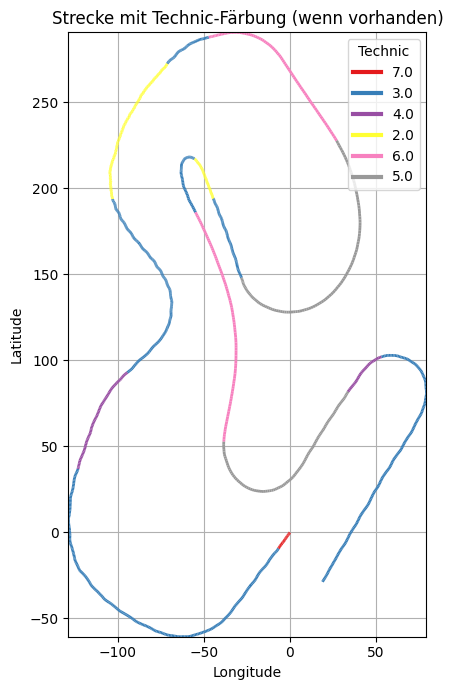

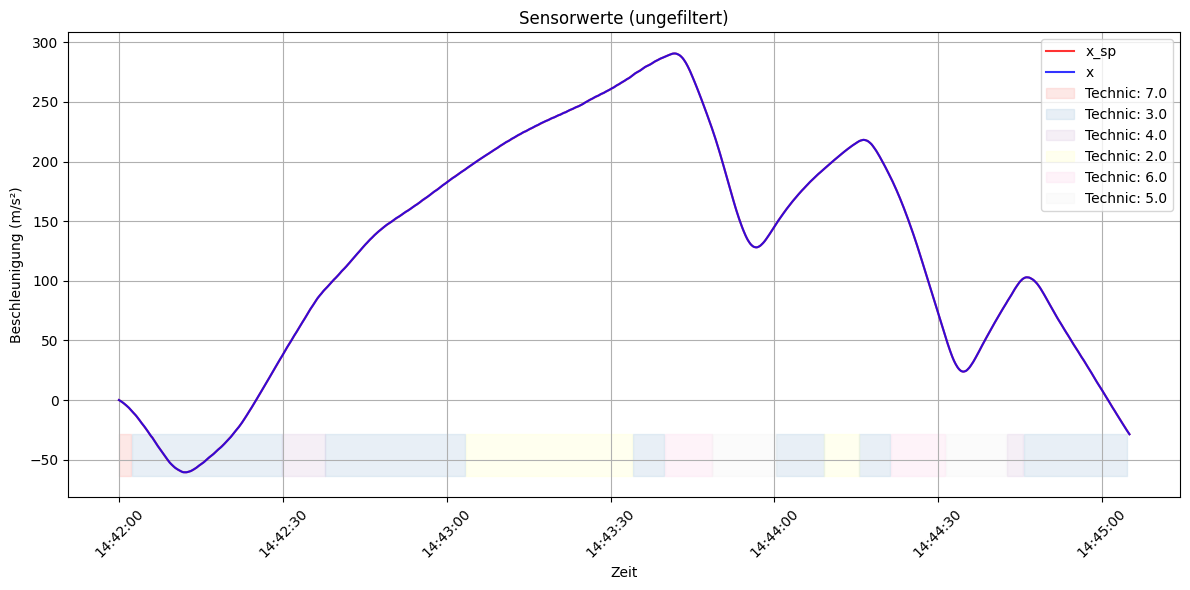

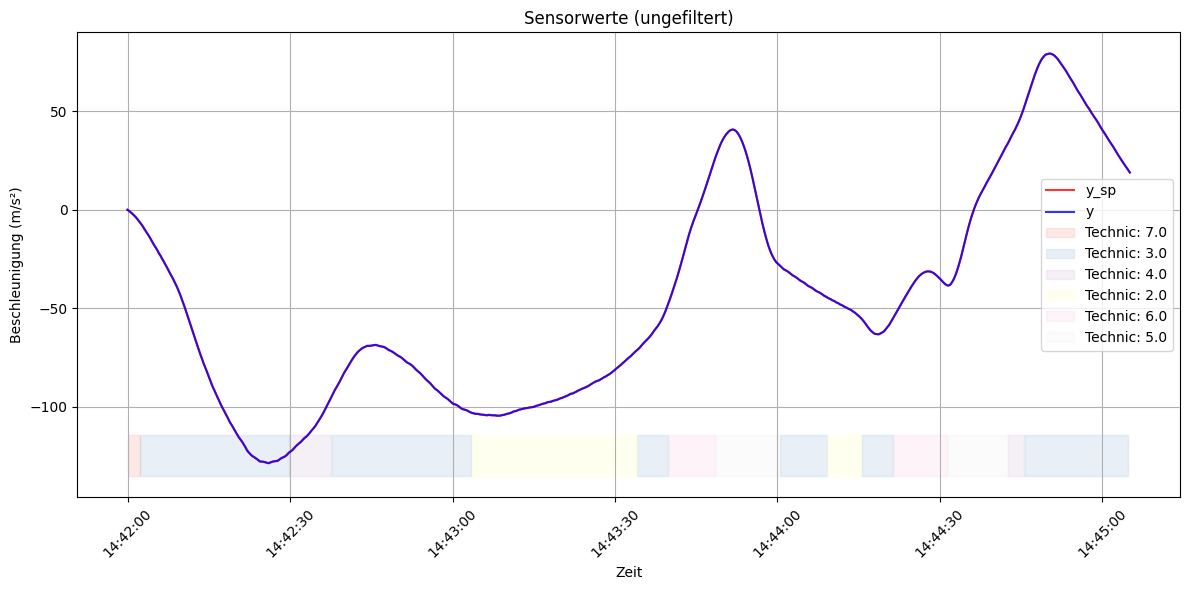

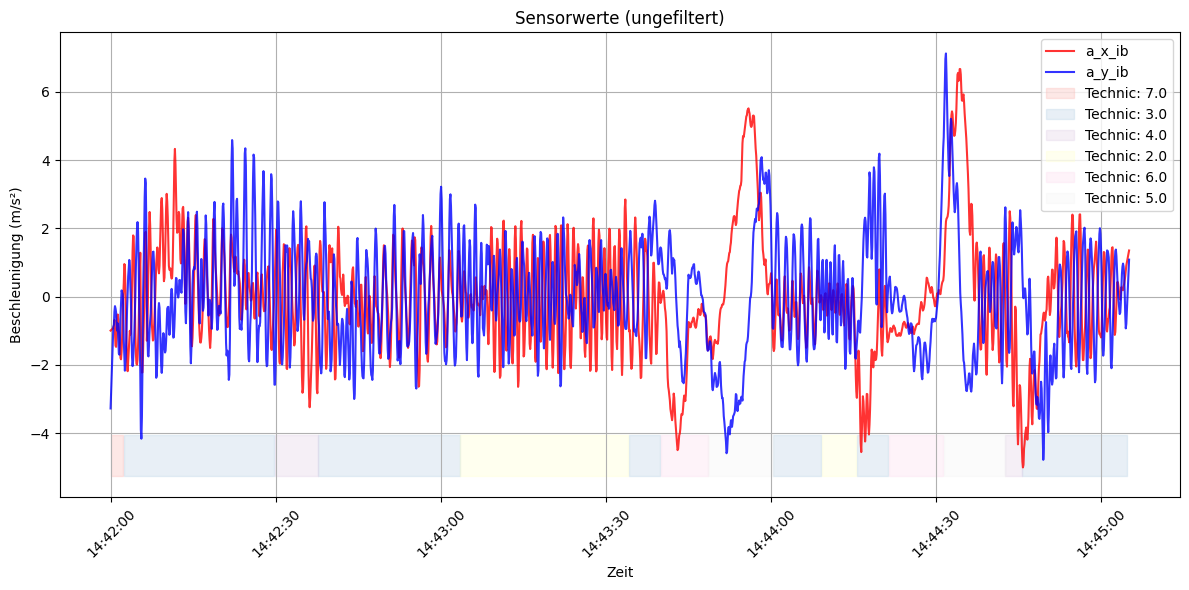

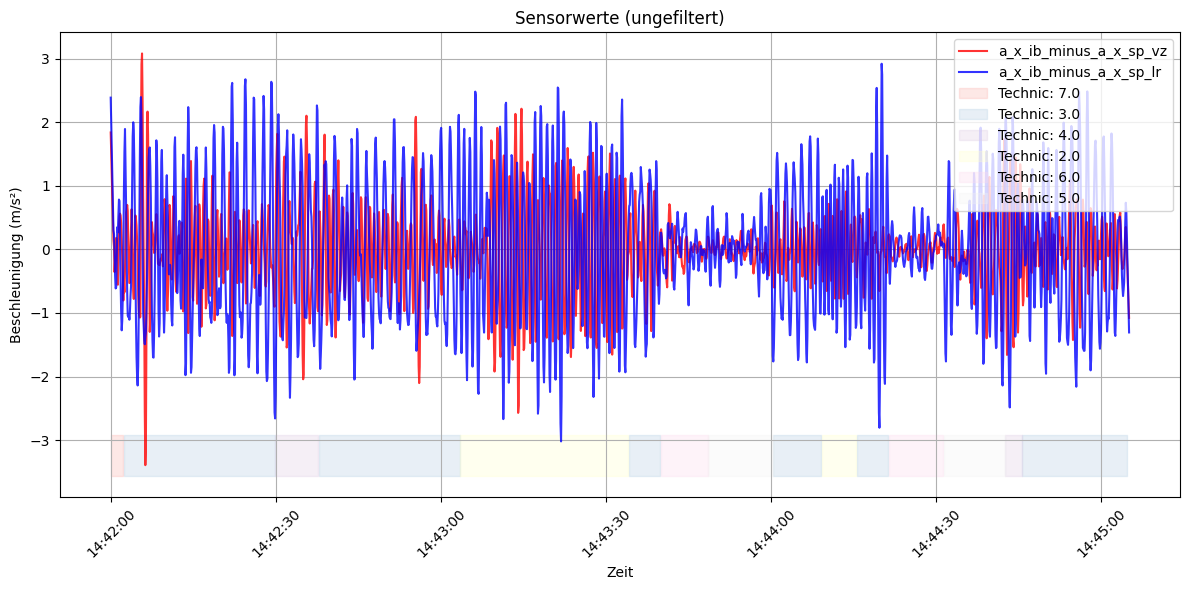

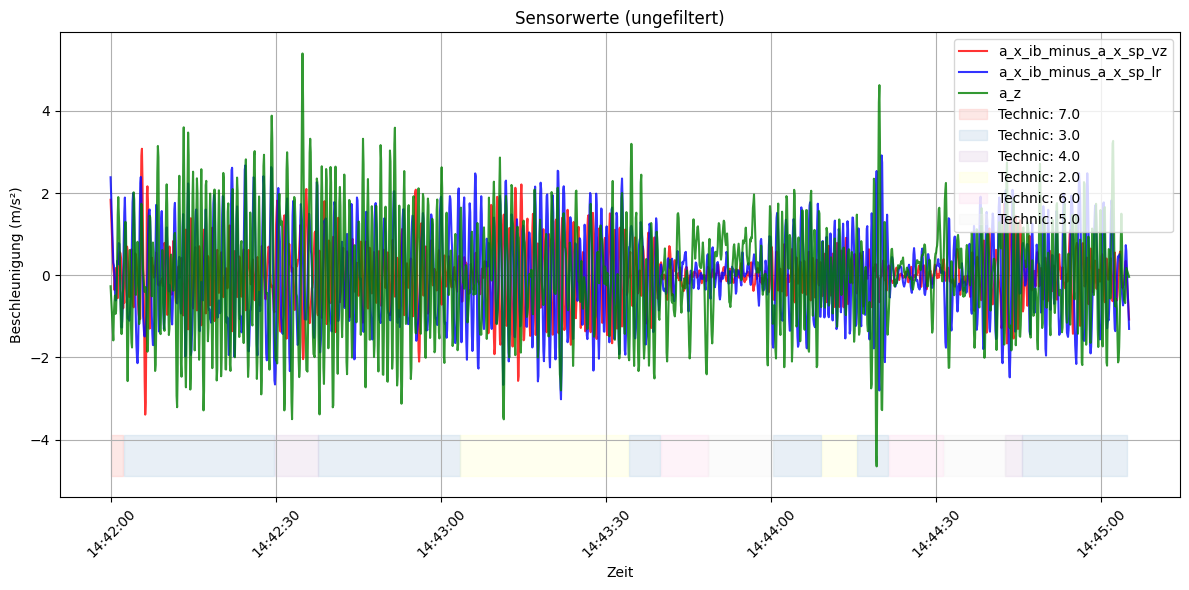

In [53]:
nadine_2 = Process_preprocess(nadine_2, sp_window=21, acc_window=11, delta=0.1)

In [58]:
nadine_2[["a_x_ib_minus_a_x_sp_vz", "a_x_ib_minus_a_x_sp_lr", "a_z"]]

,a_x_ib_minus_a_x_sp_vz,a_x_ib_minus_a_x_sp_lr,a_z
0,1.837587,2.385424,-0.268298
1,1.486829,1.980149,-0.531935
2,1.145698,1.567232,-0.795571
3,0.812071,1.148511,-1.059207
4,0.483962,0.725617,-1.322844
...,...,...,...
1848,-0.063793,0.202220,0.134848
1849,-0.307747,-0.180964,0.091142
1850,-0.560031,-0.558470,0.047436
1851,-0.822296,-0.928974,0.003730


# Zyklen detektieren (dazu Signal_projektion weiterentwickeln)

### lokales min, max finden

### Abstand der Min/max bestimmen

### Länge pro Zyklus pro Technick bestimmen (sollte für jede Technik etwa gleich sein)

### Zyklen in Zeitreihe darstellen

### Resampling

# Zyklen darstellen (pro technic alle wie Stöggle)

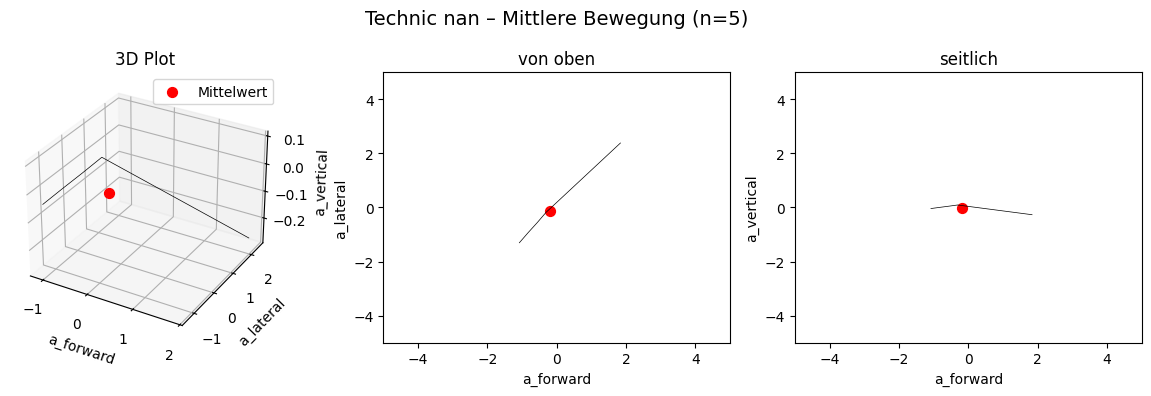

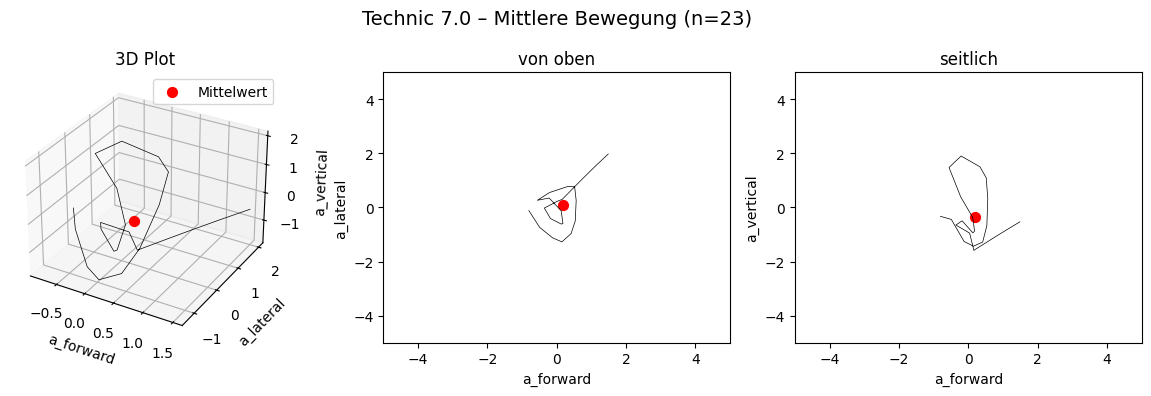

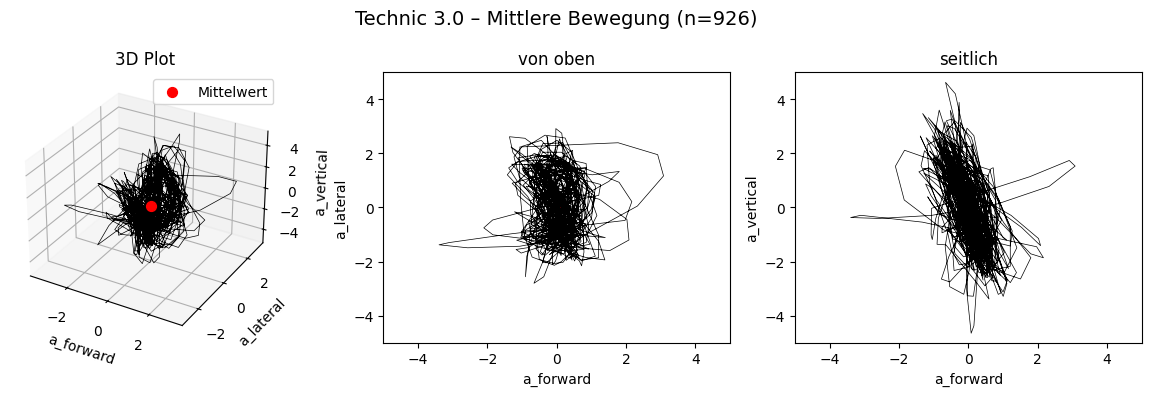

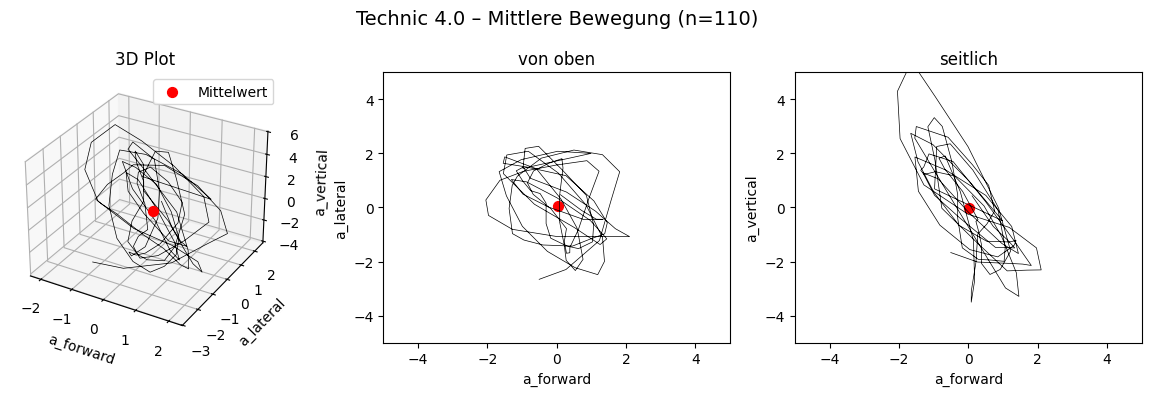

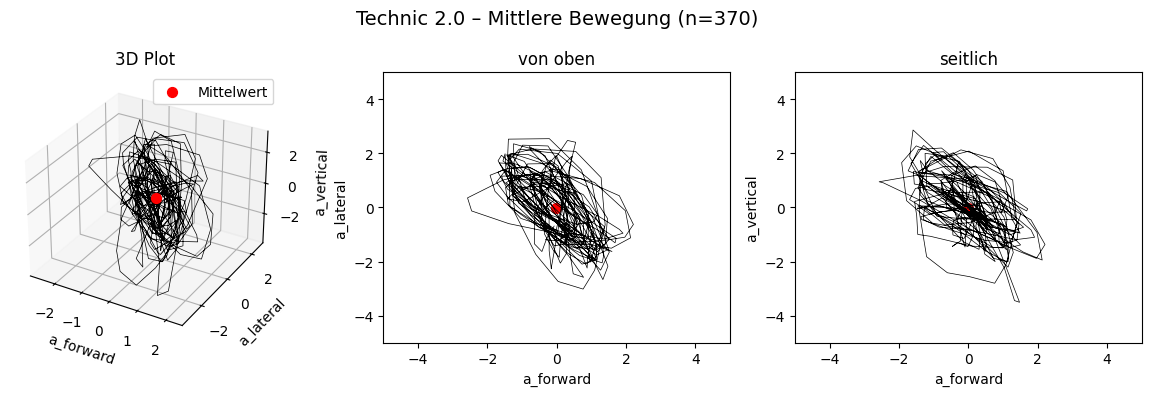

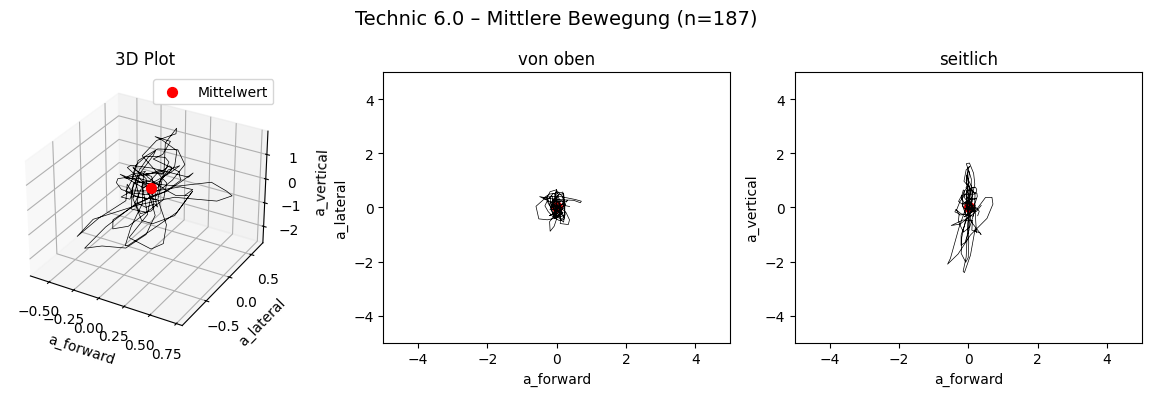

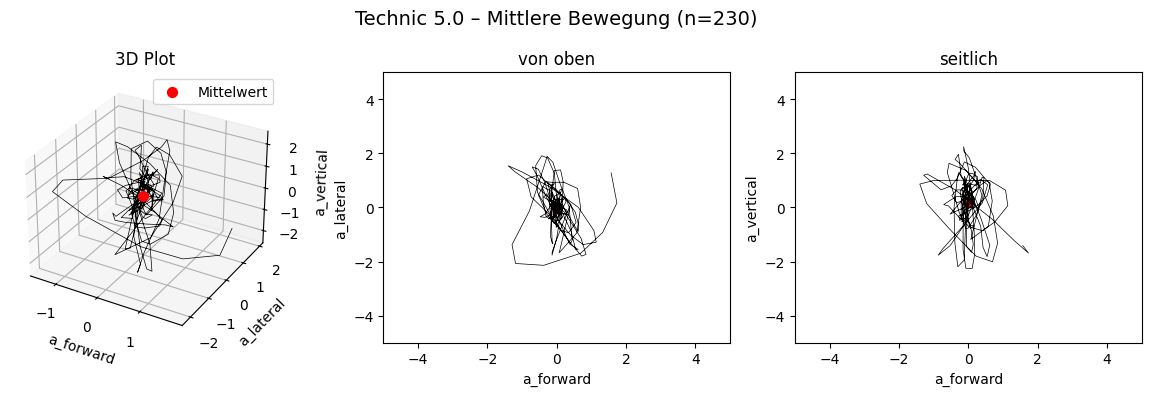

In [54]:
plot_mean_trajectory(nadine_2, a_x_col="a_x_ib_minus_a_x_sp_vz", a_y_col="a_x_ib_minus_a_x_sp_lr", a_z_col="a_z")

In [ ]:
plot_mean_cycles(nadine_2, a_x_col="a_x_ib_minus_a_x_sp_vz", a_y_col="a_x_ib_minus_a_x_sp_lr", a_z_col="a_z",distance=10, N=100)